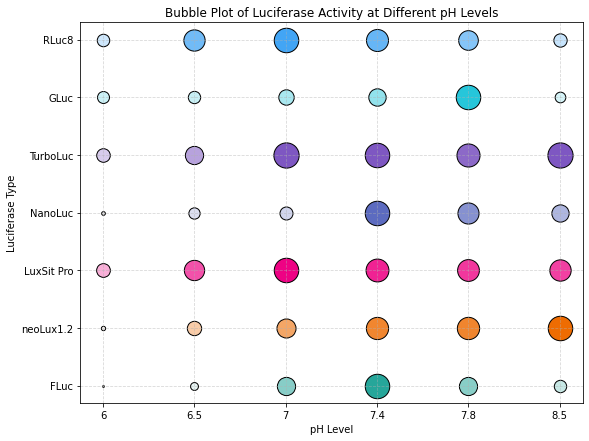

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
ph_labels = ["6", "6.5", "7", "7.4", "7.8", "8.5"]  # pH levels as labels
luciferases = ["FLuc", "neoLux1.2", "LuxSit Pro", "NanoLuc", "TurboLuc", "GLuc", "RLuc8"]
activity_data = np.array([
    [0.005272, 0.103497, 0.553517, 1, 0.550847, 0.255572],
    [0.030647, 0.342492, 0.605284, 0.822985, 0.828534, 1],
    [0.314499, 0.685938, 1, 0.872876, 0.790322, 0.757177],
    [0.022973, 0.213293, 0.282387, 1, 0.74251, 0.496],
    [0.307542, 0.553316, 1.063151, 1, 0.889118, 1.056737],
    [0.238696, 0.252612, 0.395347, 0.502988, 1, 0.18859],
    [0.258986, 0.753474, 1, 0.806409, 0.642448, 0.295972],
])

# Define custom colors for each luciferase (hex to RGB)
luciferase_colors = {
    "FLuc": "#26A69A",
    "neoLux1.2": "#ee6c02",
    "LuxSit Pro": "#ee0284",
    "NanoLuc": "#5C6BC0",
    "TurboLuc": "#7E57C2",
    "GLuc": "#26C6DA",
    "RLuc8": "#42A5F5"
}

# Scale bubble size
bubble_size = activity_data * 600  # Adjust size scaling factor

# Create equal spacing for pH labels
ph_positions = np.arange(len(ph_labels))  # Equal interval x positions

# Create bubble plot
plt.figure(figsize=(9, 7))

# Generate bubbles with assigned colors
for i, luc in enumerate(luciferases):
    base_color = np.array([int(luciferase_colors[luc][1:3], 16) / 255,
                           int(luciferase_colors[luc][3:5], 16) / 255,
                           int(luciferase_colors[luc][5:7], 16) / 255])  # Convert hex to RGB
    
    for j, ph_pos in enumerate(ph_positions):
        alpha_value = max(0, min(1, activity_data[i, j]))  # Ensure alpha is between 0 and 1
        plt.scatter(ph_pos, i, s=bubble_size[i, j], 
                    color=[(*base_color, alpha_value)], edgecolors='k')

# Customize plot
plt.xticks(ph_positions, ph_labels)  # Set x-axis ticks to pH labels
plt.yticks(range(len(luciferases)), luciferases)  # Set y-axis labels
plt.xlabel("pH Level")
plt.ylabel("Luciferase Type")
plt.title("Bubble Plot of Luciferase Activity at Different pH Levels")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
import os

# Define the simplified model without Hill coefficient and gamma.
# y = Vmin + (Vmax - Vmin) / [1 + (EC50/x) + (x/Ki)]
def simple_model(x, Vmin, Vmax, EC50, Ki):
    x = np.asarray(x)
    # Avoid division by zero: when x==0, set the activation term to infinity so that response equals Vmin.
    term1 = np.where(x == 0, np.inf, (EC50 / x))
    # When x==0, inhibition term is defined as 0.
    term2 = np.where(x == 0, 0, (x / Ki))
    return Vmin + (Vmax - Vmin) / (1 + term1 + term2)

# Create folder "fig" if it doesn't exist.
os.makedirs("fig", exist_ok=True)

# Path to your Excel file with multiple sheets.
excel_file = "data1.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# Dictionary to hold the parameter DataFrames from each sheet.
param_tables = {}

# Loop over each sheet (dataset) in the Excel file.
for sheet in sheet_names:
    # Read the dataset from the current sheet.
    df = pd.read_excel(excel_file, sheet_name=sheet, header=0)
    
    # Rename the first column (A1 is the title) to "Time" so that column A (from A2 onward) holds time (in minutes).
    time_col = df.columns[0]
    df.rename(columns={time_col: "Time"}, inplace=True)
    
    # Group columns by their substrate concentration.
    # Convert headers (cells from B1 onward) to strings and extract the leading numeric value.
    replicate_dict = {}
    for col in df.columns[1:]:
        match = re.match(r'^([0-9]*\.?[0-9]+)', str(col))
        if match:
            conc = match.group(1)
        else:
            conc = str(col)
        replicate_dict.setdefault(conc, []).append(col)
    
    # Create a new DataFrame (avg_df) that stores the average signal for each unique substrate concentration.
    avg_df = pd.DataFrame()
    avg_df["Time"] = df["Time"]
    # Sort unique concentrations numerically.
    unique_concs = sorted(replicate_dict.keys(), key=lambda x: float(x))
    for conc in unique_concs:
        cols = replicate_dict[conc]
        avg_df[str(conc)] = df[cols].mean(axis=1)
    
    # Set up a figure for the current dataset.
    plt.figure(figsize=(10, 8))
    # Use a colormap to assign a different color for each timepoint.
    colors = plt.cm.viridis(np.linspace(0, 1, len(avg_df)))
    
    # List to store fitted parameters for each time point in this dataset.
    fit_params_list = []
    
    # Loop over each time point (each row in avg_df).
    for i, row in avg_df.iterrows():
        time_value = row["Time"]
        # x: substrate concentrations (converted to floats)
        x = np.array([float(c) for c in unique_concs])
        # y: average responses at this time point.
        y = row[[str(c) for c in unique_concs]].values.astype(float)
        
        # Initial guesses for parameters:
        # Vmin = min(y), Vmax = max(y), EC50 = median(x), Ki = max(x)
        p0 = [min(y), max(y), np.median(x), max(x)]
        
        try:
            popt, _ = curve_fit(simple_model, x, y, p0=p0, maxfev=10000)
            fitted_EC50 = popt[2]
            fitted_Ki = popt[3]
            # Record fitted parameters.
            fit_params_list.append({
                "Time (min)": time_value,
                "Vmin": popt[0],
                "Vmax": popt[1],
                "EC50": popt[2],
                "Ki": popt[3]
            })
            
            # Generate a smooth fitted curve.
            x_fit = np.linspace(min(x), max(x), 100)
            y_fit = simple_model(x_fit, *popt)
            
            # Plot original data points.
            plt.scatter(x, y, color=colors[i], edgecolor='k', s=50, zorder=3)
            # Plot the fitted curve.
            plt.plot(x_fit, y_fit, color=colors[i], label=f"Time {time_value} min")
            # Draw a dashed vertical line at the fitted EC50.
            plt.axvline(x=fitted_EC50, color=colors[i], linestyle="--",
                        label=f"EC50: {fitted_EC50:.2f}" if i == 0 else "")
            # Draw a dotted vertical line at the fitted Ki.
            plt.axvline(x=fitted_Ki, color=colors[i], linestyle=":",
                        label=f"Ki: {fitted_Ki:.2f}" if i == 0 else "")
        except Exception as e:
            print(f"Could not fit curve for time {time_value} min in sheet {sheet}: {e}")
    
    plt.xlabel("Substrate Concentration")
    plt.ylabel("Luminescence Signal")
    plt.title(f"Dose Response Curves for {sheet}")
    plt.xscale("log")  # Logarithmic scale for the x-axis.
    plt.legend()
    
    # Save the figure to the "fig" folder with a filename based on the sheet name.
    fig_filename = os.path.join("fig1", f"{sheet}.png")
    plt.savefig(fig_filename)
    plt.close()
    
    # Convert the list of fitted parameters into a DataFrame and store it.
    param_tables[sheet] = pd.DataFrame(fit_params_list)

# Write all the parameter tables to a new Excel file with each sheet corresponding to a dataset.
with pd.ExcelWriter("fitting_parameters.xlsx") as writer:
    for sheet, param_df in param_tables.items():
        param_df.to_excel(writer, sheet_name=sheet, index=False)

print("Processing complete.")
print("Figures saved in the 'fig' folder and fitted parameters saved in 'fitting_parameters.xlsx'.")

Processing complete.
Figures saved in the 'fig' folder and fitted parameters saved in 'fitting_parameters.xlsx'.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
import os

# Define the Hill equation with handling for x==0.
def hill_equation(x, Vmin, Vmax, EC50, Hill):
    x = np.asarray(x)
    # When x is zero, (EC50/x)**Hill becomes inf so that the response is Vmin.
    term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
    return Vmin + (Vmax - Vmin) / (1 + term)

# Create a folder named "fig" if it doesn't exist.
os.makedirs("fig2", exist_ok=True)

# Path to your Excel file with multiple sheets.
excel_file = "data2.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# Dictionary to hold the parameter DataFrames from each sheet.
param_tables = {}

# Loop over each sheet (dataset) in the Excel file.
for sheet in sheet_names:
    # Read the dataset from the current sheet.
    df = pd.read_excel(excel_file, sheet_name=sheet, header=0)
    
    # Rename the first column (A1, the title) to "Time" so that column A (from A2) holds time in minutes.
    time_col = df.columns[0]
    df.rename(columns={time_col: "Time"}, inplace=True)
    
    # Group columns by substrate concentration (from row 1, cells B1 onward).
    # Convert each header to a string and extract the leading numeric value.
    replicate_dict = {}
    for col in df.columns[1:]:
        match = re.match(r'^([0-9]*\.?[0-9]+)', str(col))
        if match:
            conc = match.group(1)
        else:
            conc = str(col)
        replicate_dict.setdefault(conc, []).append(col)
    
    # Create a new DataFrame (avg_df) that stores the average signal per unique substrate concentration.
    avg_df = pd.DataFrame()
    avg_df["Time"] = df["Time"]
    # Sort unique concentrations numerically.
    unique_concs = sorted(replicate_dict.keys(), key=lambda x: float(x))
    for conc in unique_concs:
        cols = replicate_dict[conc]
        avg_df[str(conc)] = df[cols].mean(axis=1)
    
    # Set up a figure for the current dataset.
    plt.figure(figsize=(10, 8))
    # Use a colormap with one color per timepoint.
    colors = plt.cm.viridis(np.linspace(0, 1, len(avg_df)))
    
    # List to store fitted parameters for each time point in this dataset.
    fit_params_list = []
    
    # Loop over each time point (each row in avg_df).
    for i, row in avg_df.iterrows():
        time_value = row["Time"]
        # x: substrate concentrations (converted to floats)
        x = np.array([float(c) for c in unique_concs])
        # y: average responses at this time point.
        y = row[[str(c) for c in unique_concs]].values.astype(float)
        
        # Initial guess: Vmin = min(y), Vmax = max(y), EC50 = median(x), Hill coefficient = 1.
        p0 = [min(y), max(y), np.median(x), 1]
        
        try:
            popt, _ = curve_fit(hill_equation, x, y, p0=p0, maxfev=10000)
            fitted_EC50 = popt[2]
            # Record fitted parameters.
            fit_params_list.append({
                "Time (min)": time_value,
                "Vmin": popt[0],
                "Vmax": popt[1],
                "EC50": popt[2],
                "Hill": popt[3]
            })
            
            # Generate a smooth fitted curve.
            x_fit = np.linspace(min(x), max(x), 100)
            y_fit = hill_equation(x_fit, *popt)
            
            # Plot original data points.
            plt.scatter(x, y, color=colors[i], edgecolor='k', s=50, zorder=3)
            # Plot the fitted curve.
            plt.plot(x_fit, y_fit, color=colors[i], label=f"Time {time_value} min")
            # Plot a dashed vertical line at the fitted EC50.
            plt.axvline(x=fitted_EC50, color=colors[i], linestyle="--")
        except Exception as e:
            print(f"Could not fit curve for time {time_value} min in sheet {sheet}: {e}")
    
    plt.xlabel("Substrate Concentration")
    plt.ylabel("Luminescence Signal")
    plt.title(f"Dose Response Curves for {sheet}")
    plt.xscale("log")  # Log scale on the x-axis.
    plt.legend()
    
    # Save the figure to the "fig" folder with a filename based on the sheet name.
    fig_filename = os.path.join("fig2", f"{sheet}.png")
    plt.savefig(fig_filename)
    plt.close()
    
    # Convert the list of fitted parameters into a DataFrame and store it.
    param_tables[sheet] = pd.DataFrame(fit_params_list)

# Write all the parameter tables to a new Excel file with each sheet corresponding to a dataset.
with pd.ExcelWriter("fitting_parameters2.xlsx") as writer:
    for sheet, param_df in param_tables.items():
        param_df.to_excel(writer, sheet_name=sheet, index=False)

print("Processing complete.")
print("Figures saved in the 'fig' folder and fitted parameters saved in 'fitting_parameters.xlsx'.")


C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf

C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf

C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
C:\Users\sxzxc\AppData\Local\Temp/ipykernel_5140/2862318548.py:12: RuntimeWarning: invalid value encountered in power
  term = np.where(x == 0, np.inf

Processing complete.
Figures saved in the 'fig' folder and fitted parameters saved in 'fitting_parameters.xlsx'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
import os

# Define the Hill equation with handling for x==0.
def hill_equation(x, Vmin, Vmax, EC50, Hill):
    x = np.asarray(x)
    # When x is zero, (EC50/x)**Hill becomes inf so that the response is Vmin.
    term = np.where(x == 0, np.inf, (EC50 / x)**Hill)
    return Vmin + (Vmax - Vmin) / (1 + term)

# Create a folder named "fig" if it doesn't exist.
os.makedirs("fig3", exist_ok=True)

# Path to your Excel file with multiple sheets.
excel_file = "data3.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# Dictionary to hold the parameter DataFrames from each sheet.
param_tables = {}

# Loop over each sheet (dataset) in the Excel file.
for sheet in sheet_names:
    # Read the dataset from the current sheet.
    df = pd.read_excel(excel_file, sheet_name=sheet, header=0)
    
    # Rename the first column (A1, the title) to "Time" so that column A (from A2) holds time in minutes.
    time_col = df.columns[0]
    df.rename(columns={time_col: "Time"}, inplace=True)
    
    # Group columns by substrate concentration (from row 1, cells B1 onward).
    # Convert each header to a string and extract the leading numeric value.
    replicate_dict = {}
    for col in df.columns[1:]:
        match = re.match(r'^([0-9]*\.?[0-9]+)', str(col))
        if match:
            conc = match.group(1)
        else:
            conc = str(col)
        replicate_dict.setdefault(conc, []).append(col)
    
    # Create a new DataFrame (avg_df) that stores the average signal per unique substrate concentration.
    avg_df = pd.DataFrame()
    avg_df["Time"] = df["Time"]
    # Sort unique concentrations numerically.
    unique_concs = sorted(replicate_dict.keys(), key=lambda x: float(x))
    for conc in unique_concs:
        cols = replicate_dict[conc]
        avg_df[str(conc)] = df[cols].mean(axis=1)
    
    # Set up a figure for the current dataset.
    plt.figure(figsize=(10, 8))
    # Use a colormap with one color per timepoint.
    colors = plt.cm.viridis(np.linspace(0, 1, len(avg_df)))
    
    # List to store fitted parameters for each time point in this dataset.
    fit_params_list = []
    
    # Loop over each time point (each row in avg_df).
    for i, row in avg_df.iterrows():
        time_value = row["Time"]
        # x: substrate concentrations (converted to floats)
        x = np.array([float(c) for c in unique_concs])
        # y: average responses at this time point.
        y = row[[str(c) for c in unique_concs]].values.astype(float)
        
        # Initial guess: Vmin = min(y), Vmax = max(y), EC50 = median(x), Hill coefficient = 1.
        p0 = [min(y), max(y), np.median(x), 1]
        
        try:
            popt, _ = curve_fit(hill_equation, x, y, p0=p0, maxfev=10000)
            fitted_EC50 = popt[2]
            # Record fitted parameters.
            fit_params_list.append({
                "Time (min)": time_value,
                "Vmin": popt[0],
                "Vmax": popt[1],
                "EC50": popt[2],
                "Hill": popt[3]
            })
            
            # Generate a smooth fitted curve.
            x_fit = np.linspace(min(x), max(x), 100)
            y_fit = hill_equation(x_fit, *popt)
            
            # Plot original data points.
            plt.scatter(x, y, color=colors[i], edgecolor='k', s=50, zorder=3)
            # Plot the fitted curve.
            plt.plot(x_fit, y_fit, color=colors[i], label=f"Time {time_value} min")
            # Plot a dashed vertical line at the fitted EC50.
            plt.axvline(x=fitted_EC50, color=colors[i], linestyle="--")
        except Exception as e:
            print(f"Could not fit curve for time {time_value} min in sheet {sheet}: {e}")
    
    plt.xlabel("Substrate Concentration")
    plt.ylabel("Luminescence Signal")
    plt.title(f"Dose Response Curves for {sheet}")
    plt.xscale("log")  # Log scale on the x-axis.
    plt.legend()
    
    # Save the figure to the "fig" folder with a filename based on the sheet name.
    fig_filename = os.path.join("fig3", f"{sheet}.png")
    plt.savefig(fig_filename)
    plt.close()
    
    # Convert the list of fitted parameters into a DataFrame and store it.
    param_tables[sheet] = pd.DataFrame(fit_params_list)

# Write all the parameter tables to a new Excel file with each sheet corresponding to a dataset.
with pd.ExcelWriter("fitting_parameters3.xlsx") as writer:
    for sheet, param_df in param_tables.items():
        param_df.to_excel(writer, sheet_name=sheet, index=False)

print("Processing complete.")
print("Figures saved in the 'fig' folder and fitted parameters saved in 'fitting_parameters.xlsx'.")


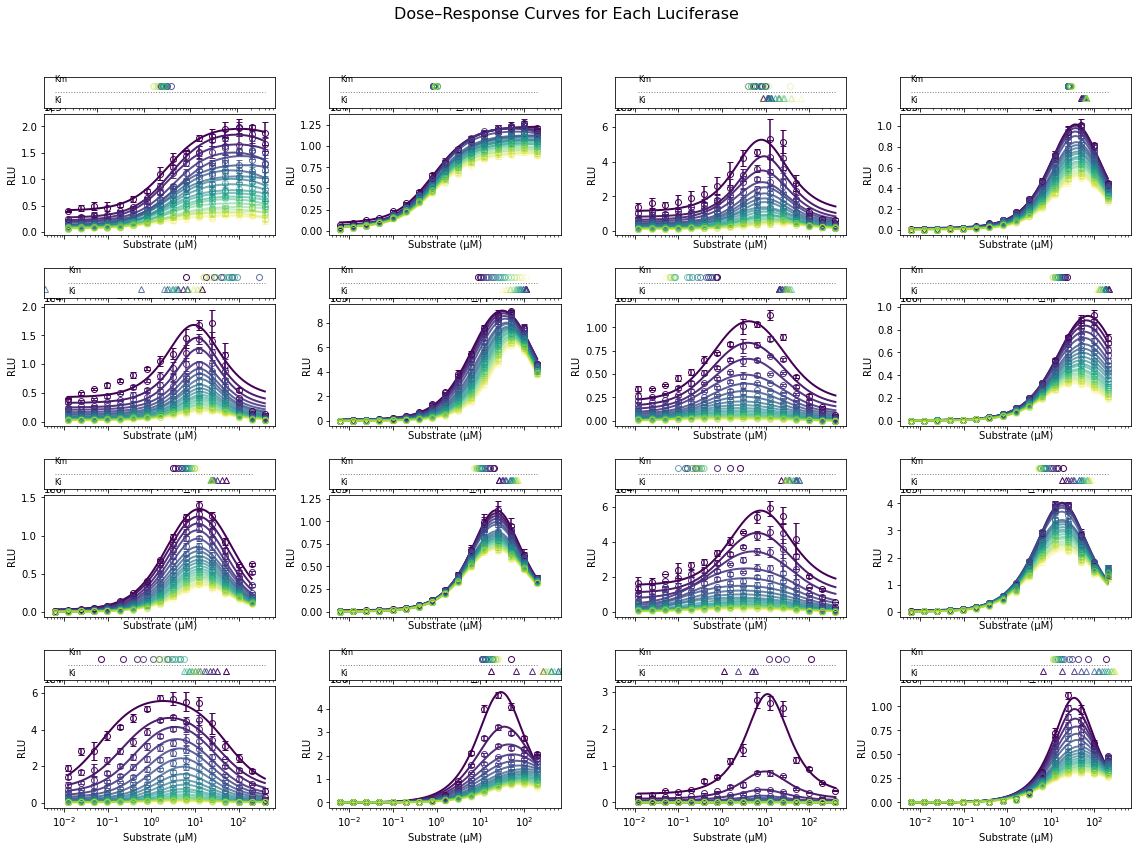

Processing complete.
Combined figure saved in 'fig/combined_luciferase_plots_grid.png' and fitting parameters saved in 'fitting_parameters.xlsx'.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import math

# -----------------------------
# Function to load data from a given sheet
# -----------------------------
def load_data_from_sheet(filepath, sheet):
    df = pd.read_excel(filepath, sheet_name=sheet, header=None)
    # First row (excluding first cell): substrate concentrations (µM)
    substrate_conc = df.iloc[0, 1:].astype(float).values  
    # First column (from row 1 onward): time points (min)
    time_points = df.iloc[1:, 0].astype(float).values  
    # Remaining cells: RLU measurements
    rlu_matrix = df.iloc[1:, 1:].astype(float).values  

    # Average every 3 columns (triplicates)
    n_reps = 3
    n_groups = rlu_matrix.shape[1] // n_reps
    substrate_avg = np.array([np.mean(substrate_conc[i*n_reps:(i+1)*n_reps])
                               for i in range(n_groups)])
    rlu_avg = np.stack([
        np.mean(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    # Standard deviation for error bars (symmetric)
    rlu_std = np.stack([
        np.std(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    
    return substrate_avg, time_points, rlu_avg, rlu_std

# -----------------------------
# Dose–response model (with baseline Vmin)
# -----------------------------
def dose_response(S, Vmin, Vmax, Km, Ki):
    # Model:
    # y = Vmin + ((Vmax - Vmin)*S)/(Km + S + (S**2)/Ki)
    S = np.asarray(S)
    return Vmin + (Vmax - Vmin) * S / (Km + S + (S**2) / Ki)

# -----------------------------
# Main script to generate grid of plots and save fitting parameters
# -----------------------------
filepath = "data1.xlsx"  # Update with your file name if needed
xls = pd.ExcelFile(filepath)
sheet_names = xls.sheet_names
num_sheets = len(sheet_names)

# Determine grid dimensions: 4 columns, number of rows as needed.
ncols = 4
nrows = math.ceil(num_sheets / ncols)

# Create the overall figure.
# We share the x-axis among subplots (log scale) while leaving the y-axis independent.
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = axes.flatten()

# Create folder "fig" if it doesn't exist.
os.makedirs("fig", exist_ok=True)

# Dictionary to store parameter DataFrames for each luciferase.
parameter_tables = {}

# Loop over each luciferase sheet.
for idx, sheet in enumerate(sheet_names):
    ax = axes[idx]
    substrate_avg, time_subset, rlu_avg, rlu_std = load_data_from_sheet(filepath, sheet)
    
    # Set up colormap for time gradient.
    norm = plt.Normalize(vmin=min(time_subset), vmax=max(time_subset))
    cmap = plt.cm.viridis
    t_min = min(time_subset)
    t_max = max(time_subset)
    
    # Generate substrate values evenly in log scale for a smooth fitted curve.
    S_fit = np.logspace(np.log10(min(substrate_avg)), np.log10(max(substrate_avg)), 200)
    
    # DataFrame to store fitted parameters for each time point.
    param_df = pd.DataFrame(columns=["Time (min)", "Vmin", "Vmax", "Km", "Ki", "Peak"])
    # Lists to accumulate Km and Ki values for ruler inset.
    km_list = []
    ki_list = []
    color_list = []
    
    # Loop over each time point.
    for i, t in enumerate(time_subset):
        y = rlu_avg[i, :]
        y_err = rlu_std[i, :]
        # Initial guesses: Choose Vmin as the minimum observed, Vmax as the maximum,
        # Km as the median substrate, and Ki as the maximum substrate.
        p0 = [min(y), max(y), np.median(substrate_avg), max(substrate_avg)]
        try:
            # Enforce nonnegative parameters by providing bounds: all parameters >= 0.
            popt, _ = curve_fit(dose_response, substrate_avg, y, p0=p0, 
                                bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]),
                                maxfev=10000)
            Vmin_fit, Vmax_fit, Km_fit, Ki_fit = popt
            y_fit = dose_response(S_fit, Vmin_fit, Vmax_fit, Km_fit, Ki_fit)
            peak = np.max(y_fit)
        except Exception as e:
            print(f"Fit failed for sheet '{sheet}' at time {t} min: {e}")
            Vmin_fit, Vmax_fit, Km_fit, Ki_fit, peak = [np.nan]*5
        
        # Append the fitted parameters.
        param_df = param_df.append({
            "Time (min)": t,
            "Vmin": Vmin_fit,
            "Vmax": Vmax_fit,
            "Km": Km_fit,
            "Ki": Ki_fit,
            "Peak": peak
        }, ignore_index=True)
        
        # Save Km and Ki for the ruler inset.
        km_list.append(Km_fit)
        ki_list.append(Ki_fit)
        
        # Determine color and transparency.
        color = cmap(norm(t))
        alpha_val = 1 - ((t - t_min) / (t_max - t_min)) * 0.8
        color_list.append((color, alpha_val))
        
        # Plot the fitted curve.
        ax.plot(S_fit, dose_response(S_fit, Vmin_fit, Vmax_fit, Km_fit, Ki_fit),
                color=color, lw=2, alpha=alpha_val)
        # Plot the original data with symmetric error bars.
        ax.errorbar(substrate_avg, y, yerr=y_err, fmt='o',
                    markerfacecolor='none', markeredgecolor=color,
                    ecolor=color, capsize=3, alpha=alpha_val)
    
    # Store parameter DataFrame for this luciferase.
    parameter_tables[sheet] = param_df.copy()
    
    # Set x-axis to log scale.
    ax.set_xscale("log")
    # Use scientific notation for y-axis.
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel("Substrate (µM)")
    ax.set_ylabel("RLU")
    ax.set_title(sheet)
    
    # --- Create an inset "ruler" plot above the main axis ---
    # The ruler will display Km (as circles at y = 0.7) and Ki (as triangles at y = 0.3).
    ruler_ax = ax.inset_axes([0, 1.05, 1, 0.25], transform=ax.transAxes)
    ruler_ax.set_xscale("log")
    ruler_ax.get_yaxis().set_visible(False)
    ruler_ax.set_xlim(ax.get_xlim())
    ruler_ax.set_ylim(0, 1)
    # Draw a horizontal dotted line as the base.
    ruler_ax.hlines(0.5, xmin=min(substrate_avg), xmax=max(substrate_avg), colors="gray", linestyles="dotted", lw=1)
    # Plot each Km and Ki using the same color and alpha as the corresponding time point.
    for j in range(len(km_list)):
        ruler_ax.plot(km_list[j], 0.7, marker='o', markersize=6, markerfacecolor='none',
                      markeredgecolor=color_list[j][0], alpha=color_list[j][1])
        ruler_ax.plot(ki_list[j], 0.3, marker='^', markersize=6, markerfacecolor='none',
                      markeredgecolor=color_list[j][0], alpha=color_list[j][1])
    # Add static labels for clarity.
    ruler_ax.text(min(substrate_avg), 0.85, "Km", fontsize=8, color="black")
    ruler_ax.text(min(substrate_avg), 0.15, "Ki", fontsize=8, color="black")
    ruler_ax.tick_params(labelbottom=False)
    
# Remove any unused subplots.
for j in range(num_sheets, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Dose–Response Curves for Each Luciferase", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("fig/combined_luciferase_plots_grid.png")
plt.show()

# Save all parameter tables to an Excel file (each luciferase on its own sheet).
with pd.ExcelWriter("fitting_parameters.xlsx") as writer:
    for sheet, df_param in parameter_tables.items():
        df_param.to_excel(writer, sheet_name=sheet, index=False)

print("Processing complete.")
print("Combined figure saved in 'fig/combined_luciferase_plots_grid.png' and fitting parameters saved in 'fitting_parameters.xlsx'.")


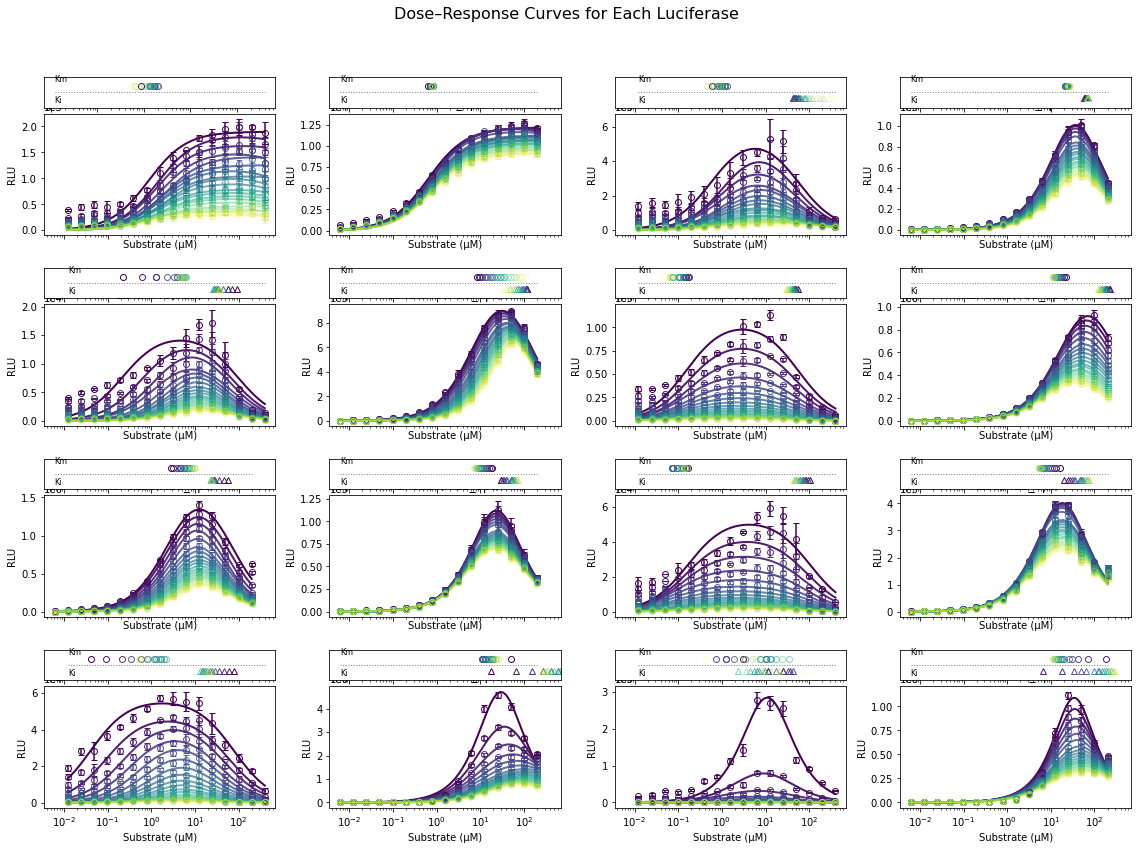

Processing complete.
Combined figure saved in 'fig/combined_luciferase_plots_grid.png' and fitting parameters saved in 'fitting_parameters.xlsx'.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import math

# -----------------------------
# Function to load data from a given sheet
# -----------------------------
def load_data_from_sheet(filepath, sheet):
    df = pd.read_excel(filepath, sheet_name=sheet, header=None)
    # First row (excluding first cell): substrate concentrations (in µM)
    substrate_conc = df.iloc[0, 1:].astype(float).values  
    # First column (from row 1 onward): time points (in minutes)
    time_points = df.iloc[1:, 0].astype(float).values  
    # Remaining cells: RLU measurements
    rlu_matrix = df.iloc[1:, 1:].astype(float).values  

    # Average every 3 columns (triplicates)
    n_reps = 3
    n_groups = rlu_matrix.shape[1] // n_reps
    substrate_avg = np.array([np.mean(substrate_conc[i*n_reps:(i+1)*n_reps])
                               for i in range(n_groups)])
    rlu_avg = np.stack([
        np.mean(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    # Standard deviation for symmetric error bars
    rlu_std = np.stack([
        np.std(rlu_matrix[:, i*n_reps:(i+1)*n_reps], axis=1)
        for i in range(n_groups)
    ], axis=1)
    
    return substrate_avg, time_points, rlu_avg, rlu_std

# -----------------------------
# Dose–response model without baseline (Vmin removed)
# -----------------------------
def dose_response(S, Vmax, Km, Ki):
    # Model:
    # y = Vmax * S / (Km + S + (S^2)/Ki)
    S = np.asarray(S)
    return Vmax * S / (Km + S + (S**2) / Ki)

# -----------------------------
# Main script to generate grid of plots and save fitting parameters
# -----------------------------
filepath = "data1.xlsx"  # Update with your data file name
xls = pd.ExcelFile(filepath)
sheet_names = xls.sheet_names
num_sheets = len(sheet_names)

# Determine grid dimensions: 4 columns, as many rows as needed.
ncols = 4
nrows = math.ceil(num_sheets / ncols)

# Create overall figure; share the x-axis among subplots (log scale) but allow independent y-axis.
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)
axes = axes.flatten()

# Create folder "fig" if it doesn't exist.
os.makedirs("fig", exist_ok=True)

# Dictionary to store parameter DataFrames for each luciferase.
parameter_tables = {}

# Loop over each sheet (each luciferase dataset)
for idx, sheet in enumerate(sheet_names):
    ax = axes[idx]
    substrate_avg, time_subset, rlu_avg, rlu_std = load_data_from_sheet(filepath, sheet)
    
    # Set up a colormap for the time gradient.
    norm = plt.Normalize(vmin=min(time_subset), vmax=max(time_subset))
    cmap = plt.cm.viridis
    t_min = min(time_subset)
    t_max = max(time_subset)
    
    # Generate substrate points in log space for smooth fitted curves.
    S_fit = np.logspace(np.log10(min(substrate_avg)), np.log10(max(substrate_avg)), 200)
    
    # DataFrame to store fitted parameters for each time point in this sheet.
    param_df = pd.DataFrame(columns=["Time (min)", "Vmax", "Km", "Ki", "Peak"])
    
    # Lists to collect Km and Ki values for the inset ruler plot.
    km_list = []
    ki_list = []
    color_list = []
    
    # Loop over each time point.
    for i, t in enumerate(time_subset):
        y = rlu_avg[i, :]
        y_err = rlu_std[i, :]
        # Initial guesses: Vmax from max observed signal, Km ~ median substrate, Ki ~ max substrate.
        p0 = [max(y), np.median(substrate_avg), max(substrate_avg)]
        try:
            popt, _ = curve_fit(dose_response, substrate_avg, y, p0=p0, maxfev=10000)
            Vmax_fit, Km_fit, Ki_fit = popt
            y_fit = dose_response(S_fit, Vmax_fit, Km_fit, Ki_fit)
            peak = np.max(y_fit)
        except Exception as e:
            print(f"Fit failed for sheet '{sheet}' at time {t} min: {e}")
            Vmax_fit, Km_fit, Ki_fit, peak = [np.nan]*4
        
        # Append parameters for current time point.
        param_df = param_df.append({
            "Time (min)": t,
            "Vmax": Vmax_fit,
            "Km": Km_fit,
            "Ki": Ki_fit,
            "Peak": peak
        }, ignore_index=True)
        
        # Save Km and Ki values (for ruler inset) with corresponding color.
        km_list.append(Km_fit)
        ki_list.append(Ki_fit)
        # Determine color and transparency for this time point.
        color = cmap(norm(t))
        alpha_val = 1 - ((t - t_min) / (t_max - t_min)) * 0.8
        color_list.append((color, alpha_val))
        
        # Plot the fitted curve.
        ax.plot(S_fit, dose_response(S_fit, Vmax_fit, Km_fit, Ki_fit), color=color, lw=2, alpha=alpha_val)
        # Plot original data points with symmetric error bars.
        ax.errorbar(substrate_avg, y, yerr=y_err, fmt='o', markerfacecolor='none', 
                    markeredgecolor=color, ecolor=color, capsize=3, alpha=alpha_val)
    
    # Store parameter DataFrame for current luciferase.
    parameter_tables[sheet] = param_df.copy()
    
    # Set x-axis to log scale.
    ax.set_xscale("log")
    # Format y-axis labels in scientific notation.
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel("Substrate (µM)")
    ax.set_ylabel("RLU")
    ax.set_title(sheet)
    
    # --- Add ruler inset above the main axis ---
    ruler_ax = ax.inset_axes([0, 1.05, 1, 0.25], transform=ax.transAxes)
    ruler_ax.set_xscale("log")
    ruler_ax.get_yaxis().set_visible(False)
    ruler_ax.set_xlim(ax.get_xlim())
    ruler_ax.set_ylim(0, 1)
    # Draw a horizontal dotted line as a base.
    ruler_ax.hlines(0.5, xmin=min(substrate_avg), xmax=max(substrate_avg), colors="gray", linestyles="dotted", lw=1)
    
    # Plot Km and Ki markers in the ruler for each time point.
    for j in range(len(km_list)):
        # Plot Km as a circle at y = 0.7.
        ruler_ax.plot(km_list[j], 0.7, marker='o', markersize=6, markerfacecolor='none',
                      markeredgecolor=color_list[j][0], alpha=color_list[j][1])
        # Plot Ki as a triangle at y = 0.3.
        ruler_ax.plot(ki_list[j], 0.3, marker='^', markersize=6, markerfacecolor='none',
                      markeredgecolor=color_list[j][0], alpha=color_list[j][1])
    # Optionally add labels in the inset.
    ruler_ax.text(min(substrate_avg), 0.85, "Km", fontsize=8, color="black")
    ruler_ax.text(min(substrate_avg), 0.15, "Ki", fontsize=8, color="black")
    ruler_ax.tick_params(labelbottom=False)
    
# Remove any unused subplots.
for j in range(num_sheets, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Dose–Response Curves for Each Luciferase", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("fig/combined_luciferase_plots_grid.png")
plt.show()

# Save all parameter tables into a single Excel file (one sheet per luciferase).
with pd.ExcelWriter("fitting_parameters0.xlsx") as writer:
    for sheet, df_param in parameter_tables.items():
        df_param.to_excel(writer, sheet_name=sheet, index=False)

print("Processing complete.")
print("Combined figure saved in 'fig/combined_luciferase_plots_grid.png' and fitting parameters saved in 'fitting_parameters.xlsx'.")
